# 🛰️ Satellite Land Cover Analysis (2‑minute quickstart)

## 1) Install
From the repo root:
- `pip install -e .`
- `pip install -e ".[notebooks]"`

## 2) Add Copernicus credentials
Set your Copernicus Data Space credentials in `config/config.yaml` (see `config/config.yaml.example`).

## 3) Run this notebook (top → bottom)
Edit **Cell 3** (Configuration):
- `CITY` (e.g. "Milan")
- `CLASSIFIER`: `"consensus"` (default), `"kmeans"` (fast), `"spectral"` (SWIR-based)
- `MAX_CLOUD_COVER`, `START_DATE`, `END_DATE`, `RADIUS_KM`, `MAX_SIZE`

Then run **Cell 5** (Run Analysis).

## What you get
Outputs are written to `data/cities/<city>/runs/<timestamp>_<classifier>/` including:
- `labels.npy`, `confidence.npy`, `run_info.json`
- optional exports: GeoTIFF / HTML report / JSON / PNG summary

In [1]:
# ========================================
# 📦 Setup (run once after kernel restart)
# ========================================

import sys
import warnings
from pathlib import Path
from datetime import datetime, timedelta

# Suppress numpy divide warnings (expected with satellite data)
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*divide.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value.*')

# Setup path (only needed when running from notebooks/)
project_root = Path.cwd().parent
if str(project_root / 'src') not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

# Core imports
from satellite_analysis import (
    analyze, 
    export_geotiff, export_report, export_json, export_image,
    export_rgb,  # NEW: RGB True Color export
)
from satellite_analysis.utils import AreaSelector
from satellite_analysis.pipelines.download_pipeline import DownloadPipeline
from satellite_analysis.exports import LAND_COVER_CLASSES

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import numpy as np

# Land cover classes (single source of truth)
CLASSES = {k: {"name": v["name"], "color": v["color"]} for k, v in LAND_COVER_CLASSES.items()}

print("✅ Ready to analyze!")
print(f"   Color palette: {[v['color'] for v in CLASSES.values()]}")

✅ Ready to analyze!
   Color palette: ['#1E90FF', '#228B22', '#CD853F', '#DC143C', '#FFD700', '#4B0082']


In [2]:
# ========================================
# ⚙️ Configuration
# ========================================

# === CITY ===
# Milan, Rome, Florence..
# Or use any city name (will geocode automatically)
CITY = "Milan"

# === AREA ===
# Radius around city center in km (defines the analysis area)
# 💡 TIP: Use smaller radius (3-5km) for dense urban areas
#         Use larger radius (15-20km) to include suburbs
RADIUS_KM = 10  # Smaller radius = more urban focus

# === DATE RANGE ===
# Leave as None to use last 60 days, or specify dates
END_DATE = None  # e.g., "2025-01-15" or None for today
START_DATE = None  # e.g., "2024-12-01" or None for 60 days before end_date

# === QUALITY FILTERS ===
MAX_CLOUD_COVER = 15  # Maximum cloud coverage % (0-100)
CROP_TO_CITY = True   # True = centered on city, False = full satellite tile

# === PROCESSING ===
MAX_SIZE = None       # Max image dimension in pixels (None = full resolution)
                      # Recommended: 2000-5000 for balance of speed/detail

# Classification method: "consensus" (default), "kmeans" (fast), "spectral" (SWIR-based)
CLASSIFIER = "kmeans"
N_CLUSTERS = 6  # Number of clusters (used for kmeans and consensus)

# RAW CLUSTERS MODE (NEW!)
# True  = Keep distinct cluster IDs (0 to N_CLUSTERS-1) - better for visualization
# False = Map clusters to semantic classes (Water, Vegetation, Urban, etc.)
RAW_CLUSTERS = True  # ⭐ Recommended for kmeans to see all clusters

# === CALCULATED DATES ===
if END_DATE is None:
    END_DATE = datetime.now().strftime("%Y-%m-%d")
if START_DATE is None:
    START_DATE = (datetime.now() - timedelta(days=60)).strftime("%Y-%m-%d")

# Show configuration
area_km2 = 3.14159 * RADIUS_KM ** 2  # Approximate circular area
clusters_str = f" ({N_CLUSTERS} clusters)" if CLASSIFIER in ("kmeans", "consensus") else ""
raw_str = " [RAW MODE]" if RAW_CLUSTERS and CLASSIFIER == "kmeans" else ""
print(f"""
📍 Analysis Configuration
{'='*40}
City:         {CITY}
Radius:       {RADIUS_KM} km (~{area_km2:.0f} km²)
Date range:   {START_DATE} to {END_DATE}
Cloud cover:  ≤{MAX_CLOUD_COVER}%
Crop to city: {CROP_TO_CITY}
Max size:     {MAX_SIZE or 'Full resolution'}
Classifier:   {CLASSIFIER}{clusters_str}{raw_str}

💡 RAW_CLUSTERS=True keeps all {N_CLUSTERS} clusters distinct!
   Set False to map to semantic classes (Water, Veg, Urban...)
""")


📍 Analysis Configuration
City:         Milan
Radius:       10 km (~314 km²)
Date range:   2025-10-31 to 2025-12-30
Cloud cover:  ≤15%
Crop to city: True
Max size:     Full resolution
Classifier:   kmeans (6 clusters) [RAW MODE]

💡 RAW_CLUSTERS=True keeps all 6 clusters distinct!
   Set False to map to semantic classes (Water, Veg, Urban...)



In [3]:
# ========================================
# 🔍 Search Available Products (Optional)
# ========================================
# Run this cell to see available products before downloading
# Skip this cell if you want to download automatically

# Get city bounding box
area_selector = AreaSelector()
bbox, metadata = area_selector.select_by_city(CITY, radius_km=RADIUS_KM)

print(f"🔍 Searching products for {CITY}...")
print(f"   Center: {metadata['center']}")
print(f"   Area: {metadata['area_km2']:.1f} km²")
print(f"   Bbox: {[round(x, 4) for x in bbox]}")

# Search products (requires API credentials)
try:
    download_pipeline = DownloadPipeline.from_config(str(project_root / "config" / "config.yaml"))
    download_pipeline._authenticate()
    
    from satellite_analysis.downloaders.catalog.sentinel_hub_catalog import SentinelHubCatalog
    catalog = SentinelHubCatalog(download_pipeline.session)
    
    results = catalog.search(
        bbox=bbox,
        start_date=START_DATE,
        end_date=END_DATE,
        cloud_cover_max=MAX_CLOUD_COVER,
        limit=20
    )
    
    products = results.get('features', [])
    
    if products:
        print(f"\n📦 Found {len(products)} products:\n")
        print(f"{'#':<3} {'Date':<12} {'Cloud%':<8} {'Product ID':<50}")
        print("-" * 80)
        for i, p in enumerate(products):
            props = p.get('properties', {})
            date = props.get('datetime', 'N/A')[:10]
            cloud = props.get('eo:cloud_cover', 'N/A')
            pid = p.get('id', 'N/A')[:48]
            print(f"{i+1:<3} {date:<12} {cloud:<8.1f} {pid}")
        
        # Store for later use
        AVAILABLE_PRODUCTS = products
        print(f"\n💡 Products stored in AVAILABLE_PRODUCTS variable")
    else:
        print("⚠️ No products found with current filters. Try:")
        print("   - Increasing MAX_CLOUD_COVER")
        print("   - Extending the date range")
        AVAILABLE_PRODUCTS = []
        
except FileNotFoundError:
    print("⚠️ Config file not found. Products will be searched during download.")
    AVAILABLE_PRODUCTS = []
except Exception as e:
    print(f"⚠️ Could not search products: {e}")
    print("   Analysis will still work - products searched during download.")
    AVAILABLE_PRODUCTS = []

🔍 Searching products for Milan...
   Center: (45.464, 9.19)
   Area: 397.7 km²
   Bbox: [9.0621, 45.374, 9.3179, 45.554]
⚠️ Could not search products: 'DownloadPipeline' object has no attribute '_authenticate'
   Analysis will still work - products searched during download.


In [4]:
# ========================================
# 🚀 Run Analysis
# ========================================

clusters_str = f" ({N_CLUSTERS} clusters)" if CLASSIFIER in ("kmeans", "consensus") else ""
raw_str = " [RAW]" if RAW_CLUSTERS and CLASSIFIER == "kmeans" else ""
print(f"🛰️ Analyzing {CITY}...")
print(f"   Classifier: {CLASSIFIER}{clusters_str}{raw_str}")
print(f"   Radius: {RADIUS_KM} km | Cloud ≤{MAX_CLOUD_COVER}% | Crop: {CROP_TO_CITY}")

result = analyze(
    CITY,
    start_date=START_DATE,
    end_date=END_DATE,
    cloud_cover=MAX_CLOUD_COVER,
    radius_km=RADIUS_KM,
    max_size=MAX_SIZE,
    crop_to_city=CROP_TO_CITY,
    classifier=CLASSIFIER,
    n_clusters=N_CLUSTERS,
    raw_clusters=RAW_CLUSTERS,  # NEW: Keep all clusters distinct
)

# Summary
print(f"\n{result.summary()}")
print(f"\n📊 Classes found: {sorted(set(result.labels.flatten()))}")

🛰️ Analyzing Milan...
   Classifier: kmeans (6 clusters) [RAW]
   Radius: 10 km | Cloud ≤15% | Crop: True

Analysis Result for Milan
  Shape: (2005, 2005)
  Classes: 6
  Confidence: 70.0%
  Downsampled: False
  Output: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\milan\runs\2025-12-30_18-53-56_kmeans
  Time: 23.6s

📊 Classes found: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5)]


C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\349812474.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  conf_cmap = plt.cm.get_cmap('YlGn')
C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\349812474.py:102: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\349812474.py:103: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  plt.savefig(result.output_dir / f"{CITY.lower()}_classification.png", dpi=150, bbox_inches='tight',
c:\TEMP_1\satellite_git_vt\satellite_git\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


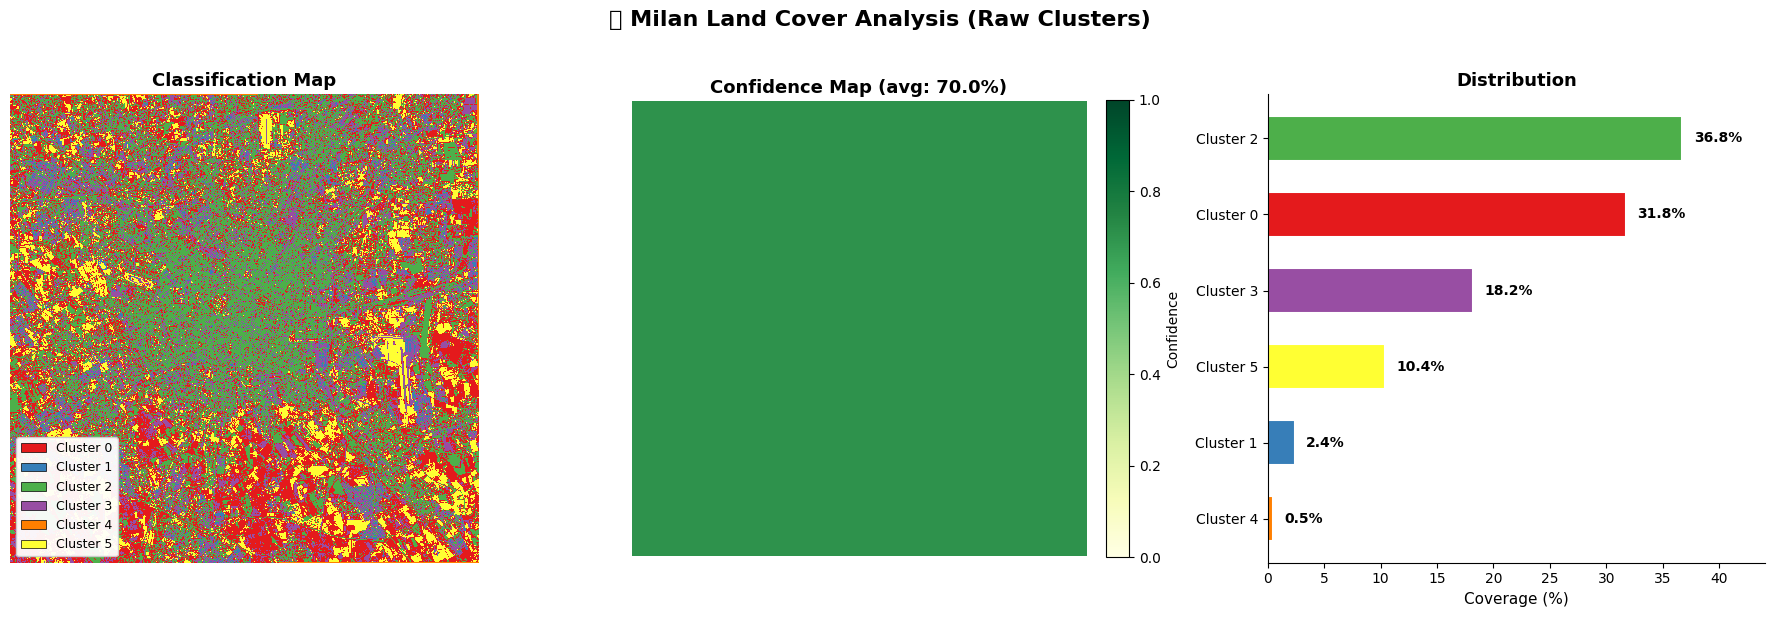


╔══════════════════════════════════════════════════════════╗
║  📊 Analysis Summary                                     ║
╠══════════════════════════════════════════════════════════╣
║  City:          Milan                                    ║
║  Image size:    2,005 × 2,005 pixels       ║
║  Total pixels:  4,020,025                               ║
║  Confidence:    70.0%                                   ║
║  Classes found: 6                                       ║
║  Mode:          Raw Clusters                             ║
║  Time:          23.6s                                   ║
╚══════════════════════════════════════════════════════════╝

📁 Output: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\milan\runs\2025-12-30_18-53-56_kmeans



In [5]:
# ========================================
# 🗺️ Visualize Results
# ========================================

# Reload class definitions (colors may have been updated)
from importlib import reload
import satellite_analysis.exports
reload(satellite_analysis.exports)
from satellite_analysis.exports import LAND_COVER_CLASSES
CLASSES = {k: {"name": v["name"], "color": v["color"]} for k, v in LAND_COVER_CLASSES.items()}

# Get unique classes in result
unique_classes = sorted(np.unique(result.labels))
n_classes = len(unique_classes)

# Check if we're in raw_clusters mode
is_raw_mode = result.classification.statistics.get("mode") == "raw_clusters"

# For raw clusters, use a distinct colormap
if is_raw_mode:
    # High-contrast palette for raw clusters
    RAW_COLORS = [
        "#E41A1C",  # Red
        "#377EB8",  # Blue  
        "#4DAF4A",  # Green
        "#984EA3",  # Purple
        "#FF7F00",  # Orange
        "#FFFF33",  # Yellow
        "#A65628",  # Brown
        "#F781BF",  # Pink
        "#999999",  # Gray
        "#66C2A5",  # Teal
    ]
    colors = [RAW_COLORS[i % len(RAW_COLORS)] for i in unique_classes]
    class_names_map = {i: f"Cluster {i}" for i in unique_classes}
else:
    colors = [CLASSES.get(i, {"color": "#808080"})["color"] for i in unique_classes]
    class_names_map = {i: CLASSES.get(i, {"name": f"Class {i}"})["name"] for i in unique_classes}

cmap = ListedColormap(colors)

# Create figure with dark style for better contrast
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
mode_str = " (Raw Clusters)" if is_raw_mode else ""
fig.suptitle(f'🛰️ {CITY} Land Cover Analysis{mode_str}', fontsize=16, fontweight='bold', y=1.02)

# 1. Land cover classification
ax1 = axes[0]
im1 = ax1.imshow(result.labels, cmap=cmap, interpolation='nearest',
                 vmin=min(unique_classes), vmax=max(unique_classes))
ax1.set_title('Classification Map', fontsize=13, fontweight='bold')
ax1.axis('off')

# Add legend with better styling
legend_elements = [Patch(facecolor=colors[i], 
                         edgecolor='black', linewidth=0.5,
                         label=class_names_map[unique_classes[i]]) 
                   for i in range(len(unique_classes))]
ax1.legend(handles=legend_elements, loc='lower left', fontsize=9,
           framealpha=0.95, fancybox=True)

# 2. Confidence map with better colormap
ax2 = axes[1]
conf_cmap = plt.cm.get_cmap('YlGn')
im2 = ax2.imshow(result.confidence, cmap=conf_cmap, vmin=0, vmax=1)
ax2.set_title(f'Confidence Map (avg: {result.avg_confidence:.1%})', fontsize=13, fontweight='bold')
ax2.axis('off')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Confidence', fontsize=10)

# 3. Class distribution with improved styling
ax3 = axes[2]
dist = result.class_distribution()
class_names = [class_names_map.get(i, f"Class {i}") for i in dist.keys()]
percentages = [d['percentage'] for d in dist.values()]
colors_bar = [colors[list(unique_classes).index(i)] if i in unique_classes else "#808080" 
              for i in dist.keys()]

# Sort by percentage for better visualization
sorted_idx = np.argsort(percentages)[::-1]
class_names = [class_names[i] for i in sorted_idx]
percentages = [percentages[i] for i in sorted_idx]
colors_bar = [colors_bar[i] for i in sorted_idx]

bars = ax3.barh(class_names, percentages, color=colors_bar, 
                edgecolor='white', linewidth=1.5, height=0.6)
ax3.set_xlabel('Coverage (%)', fontsize=11)
ax3.set_title('Distribution', fontsize=13, fontweight='bold')
ax3.set_xlim(0, max(percentages) * 1.2)
ax3.invert_yaxis()

# Add percentage labels
for bar, pct in zip(bars, percentages):
    width = bar.get_width()
    ax3.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(result.output_dir / f"{CITY.lower()}_classification.png", dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# Print summary stats
print(f"""
╔══════════════════════════════════════════════════════════╗
║  📊 Analysis Summary                                     ║
╠══════════════════════════════════════════════════════════╣
║  City:          {CITY:<40} ║
║  Image size:    {result.labels.shape[0]:,} × {result.labels.shape[1]:,} pixels{' '*(27-len(f'{result.labels.shape[0]:,} × {result.labels.shape[1]:,} pixels'))}║
║  Total pixels:  {result.total_pixels:,}{' '*(40-len(f'{result.total_pixels:,}'))}║
║  Confidence:    {result.avg_confidence:.1%}{' '*(40-len(f'{result.avg_confidence:.1%}'))}║
║  Classes found: {len(unique_classes)}{' '*(40-len(str(len(unique_classes))))}║
║  Mode:          {'Raw Clusters' if is_raw_mode else 'Semantic Classes':<40} ║
║  Time:          {result.execution_time:.1f}s{' '*(40-len(f'{result.execution_time:.1f}s'))}║
╚══════════════════════════════════════════════════════════╝

📁 Output: {result.output_dir}
""")

📁 Export directory: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\milan\runs\2025-12-30_18-53-56_kmeans



C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\297935351.py:67: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\297935351.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\297935351.py:67: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\297935351.py:67: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\297935351.py:67: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\297935351.py:68: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing fr

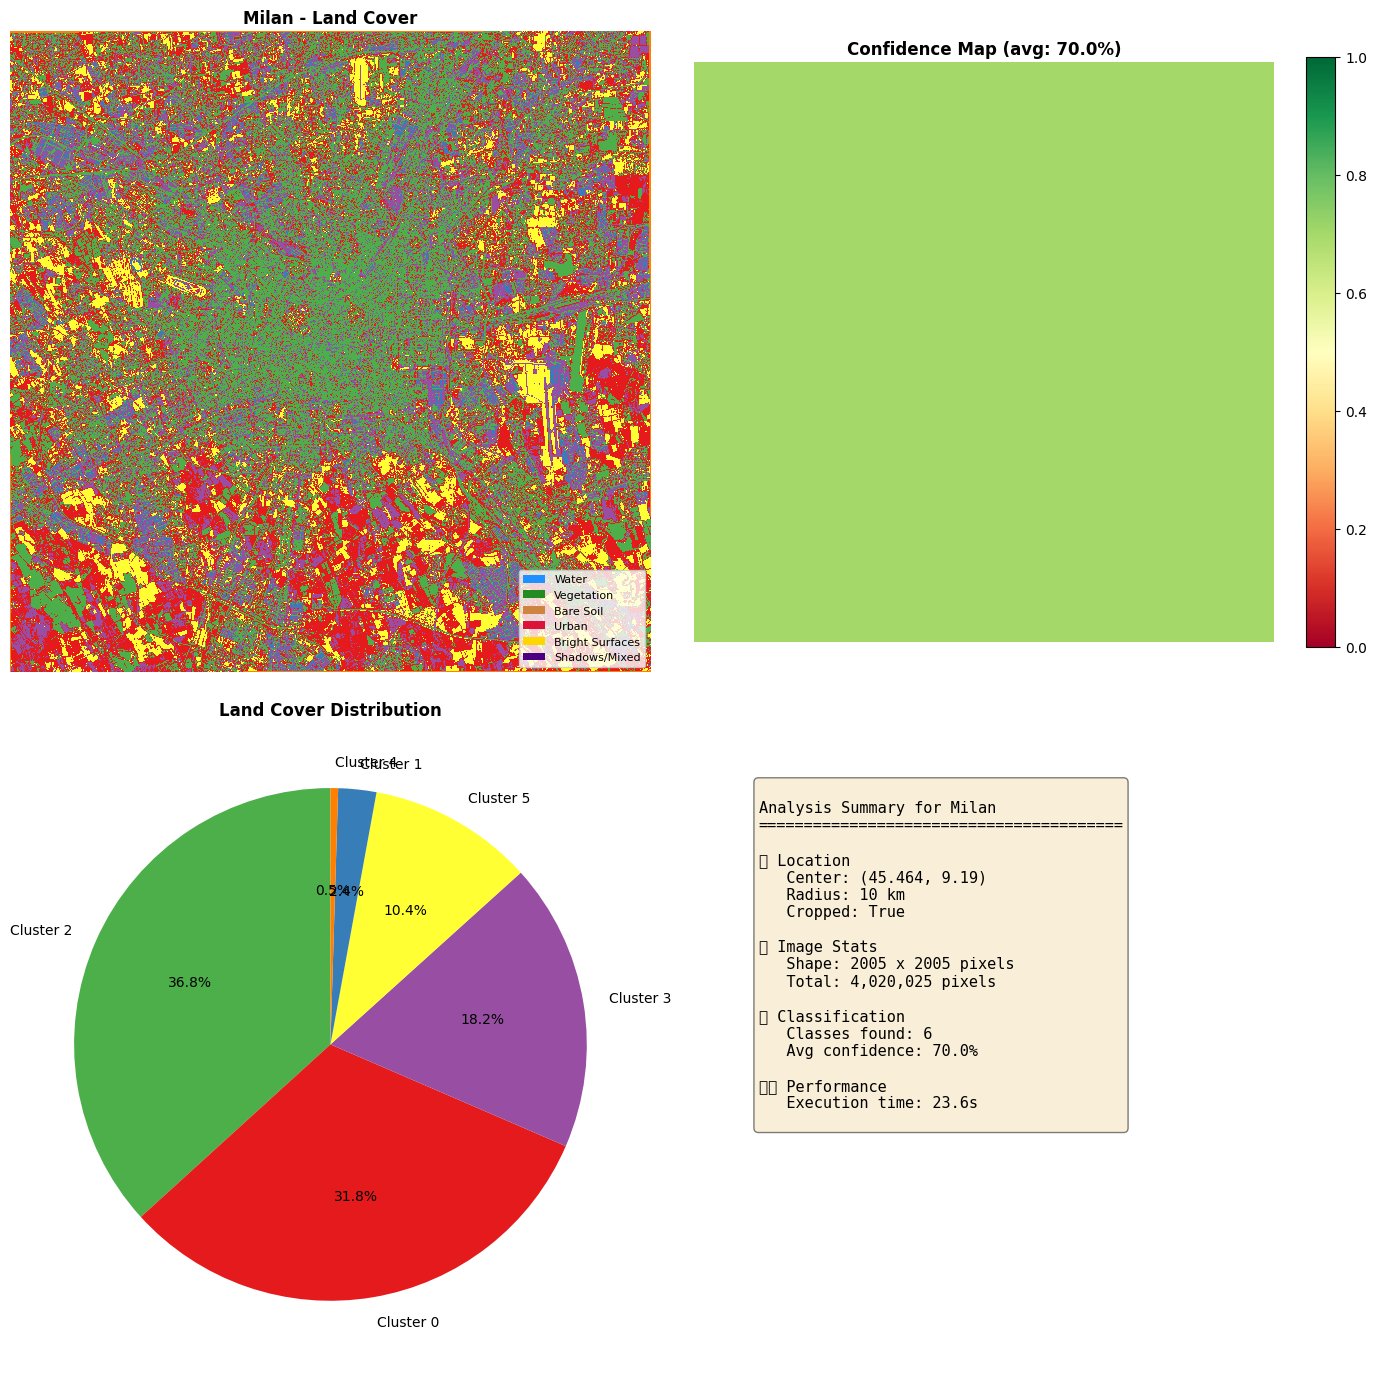


📸 Generating RGB composites from satellite bands...
✅ RGB True Color: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\milan\exports\milan_rgb.png
✅ False Color (vegetation): C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\milan\exports\milan_fcc.png
✅ NDVI visualization: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\milan\exports\milan_ndvi.png
✅ RGB GeoTIFF: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\milan\exports\milan_rgb.tif

📦 Generating analysis exports...
✅ PNG Summary: milan_summary.png
✅ GeoTIFF: milan_landcover.tif
✅ JSON: milan_data.json
✅ HTML Report: milan_report.html

📁 All exports saved to: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\milan\runs\2025-12-30_18-53-56_kmeans


In [6]:
# ========================================
# 💾 Export Results
# ========================================

# Create output directory for exports
export_dir = result.output_dir
print(f"📁 Export directory: {export_dir}\n")

# 1. Save detailed classification image (separate panels)
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 14))

# Classification map
ax = axes2[0, 0]
im = ax.imshow(result.labels, cmap=cmap, interpolation='nearest',
               vmin=min(unique_classes), vmax=max(unique_classes))
ax.set_title(f'{CITY} - Land Cover', fontsize=12, fontweight='bold')
ax.axis('off')
legend_elements = [Patch(facecolor=CLASSES[i]["color"], label=CLASSES[i]["name"]) 
                   for i in unique_classes]
ax.legend(handles=legend_elements, loc='lower right', fontsize=8)

# Confidence map
ax = axes2[0, 1]
im2 = ax.imshow(result.confidence, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_title(f'Confidence Map (avg: {result.avg_confidence:.1%})', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im2, ax=ax, fraction=0.046)

# Distribution pie chart
ax = axes2[1, 0]
wedges, texts, autotexts = ax.pie(
    percentages, 
    labels=class_names, 
    colors=colors_bar,
    autopct='%1.1f%%',
    startangle=90
)
ax.set_title('Land Cover Distribution', fontsize=12, fontweight='bold')

# Stats text
ax = axes2[1, 1]
ax.axis('off')
stats_text = f"""
Analysis Summary for {CITY}
{'='*40}

📍 Location
   Center: {result.city_center if result.city_center else 'N/A'}
   Radius: {result.radius_km} km
   Cropped: {result.cropped_to_city}

📊 Image Stats
   Shape: {result.labels.shape[0]} x {result.labels.shape[1]} pixels
   Total: {result.total_pixels:,} pixels
   
🎯 Classification
   Classes found: {len(unique_classes)}
   Avg confidence: {result.avg_confidence:.1%}
   
⏱️ Performance
   Execution time: {result.execution_time:.1f}s
"""
ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(export_dir / f"{CITY.lower()}_full_report.png", dpi=150, bbox_inches='tight')
plt.show()

# ========================================
# 🖼️ Export RGB True Color & Band Composites
# ========================================
print("\n📸 Generating RGB composites from satellite bands...")
try:
    rgb_paths = export_rgb(CITY, dpi=300)
    print(f"✅ RGB True Color: {rgb_paths.get('rgb', 'N/A')}")
    print(f"✅ False Color (vegetation): {rgb_paths.get('fcc', 'N/A')}")
    print(f"✅ NDVI visualization: {rgb_paths.get('ndvi', 'N/A')}")
    if 'rgb_geotiff' in rgb_paths:
        print(f"✅ RGB GeoTIFF: {rgb_paths['rgb_geotiff']}")
except Exception as e:
    print(f"⚠️ RGB export skipped: {e}")

# ========================================
# 📊 Standard Exports
# ========================================
print("\n📦 Generating analysis exports...")

# PNG summary (shareable quick-look)
try:
    summary_path = export_dir / f"{CITY.lower()}_summary.png"
    export_image(result, str(summary_path))
    print(f"✅ PNG Summary: {summary_path.name}")
except Exception as e:
    print(f"⚠️ PNG export skipped: {e}")

# GeoTIFF (for GIS)
try:
    geotiff_path = export_dir / f"{CITY.lower()}_landcover.tif"
    export_geotiff(result, str(geotiff_path))
    print(f"✅ GeoTIFF: {geotiff_path.name}")
except Exception as e:
    print(f"⚠️ GeoTIFF export skipped: {e}")

# JSON (machine-readable)
try:
    json_path = export_dir / f"{CITY.lower()}_data.json"
    export_json(result, str(json_path))
    print(f"✅ JSON: {json_path.name}")
except Exception as e:
    print(f"⚠️ JSON export skipped: {e}")

# HTML report
try:
    html_path = export_dir / f"{CITY.lower()}_report.html"
    export_report(result, str(html_path), language="en")
    print(f"✅ HTML Report: {html_path.name}")
except Exception as e:
    print(f"⚠️ HTML export skipped: {e}")

print(f"\n📁 All exports saved to: {export_dir}")

In [7]:
# ========================================
# 🖼️ View RGB Composites (for academic reports)
# ========================================

from PIL import Image

# Load and display the generated composites
exports_dir = project_root / "data" / "cities" / CITY.lower() / "exports"

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'🛰️ {CITY} - Satellite Band Composites (Publication Quality)', fontsize=14, fontweight='bold')

# RGB True Color
try:
    rgb_img = Image.open(exports_dir / f"{CITY.lower()}_rgb.png")
    axes[0].imshow(rgb_img)
    axes[0].set_title('RGB True Color\n(B4-B3-B2)', fontsize=11)
    axes[0].axis('off')
except FileNotFoundError:
    axes[0].text(0.5, 0.5, 'RGB not found', ha='center', va='center')
    axes[0].axis('off')

# False Color Composite (vegetation emphasis)
try:
    fcc_img = Image.open(exports_dir / f"{CITY.lower()}_fcc.png")
    axes[1].imshow(fcc_img)
    axes[1].set_title('False Color Composite\n(NIR-R-G: vegetation in red)', fontsize=11)
    axes[1].axis('off')
except FileNotFoundError:
    axes[1].text(0.5, 0.5, 'FCC not found', ha='center', va='center')
    axes[1].axis('off')

# NDVI
try:
    ndvi_img = Image.open(exports_dir / f"{CITY.lower()}_ndvi.png")
    axes[2].imshow(ndvi_img)
    axes[2].set_title('NDVI\n(Vegetation Index)', fontsize=11)
    axes[2].axis('off')
except FileNotFoundError:
    axes[2].text(0.5, 0.5, 'NDVI not found', ha='center', va='center')
    axes[2].axis('off')

plt.tight_layout()
plt.savefig(result.output_dir / f"{CITY.lower()}_composites_overview.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"""
📚 For Academic Reports:
   • RGB True Color: Natural appearance, good for localization
   • False Color: Red = healthy vegetation (NIR reflectance)
   • NDVI: Quantitative vegetation index (-1 to +1)
   
   High-res exports (300 DPI) in: {exports_dir}
""")

C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\2429404783.py:43: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\2429404783.py:44: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  plt.savefig(result.output_dir / f"{CITY.lower()}_composites_overview.png", dpi=150, bbox_inches='tight')



📚 For Academic Reports:
   • RGB True Color: Natural appearance, good for localization
   • False Color: Red = healthy vegetation (NIR reflectance)
   • NDVI: Quantitative vegetation index (-1 to +1)

   High-res exports (300 DPI) in: c:\TEMP_1\satellite_git_vt\satellite_git\data\cities\milan\exports



C:\Users\DELIAVI7\AppData\Local\Temp\ipykernel_30804\2429404783.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## 🔄 Advanced: Temporal Comparison

Use the cells below to compare changes over time between two dates.

In [ ]:
# ========================================
# 🔄 Temporal Comparison (Optional)
# ========================================
# Compare two time periods to detect land cover changes

# Skip this cell unless you have data for two different time periods
# Uncomment below to run

# from satellite_analysis import compare
#
# # Analyze two time periods
# result_2023 = analyze(CITY, start_date="2023-06-01", end_date="2023-08-31", max_size=MAX_SIZE)
# result_2024 = analyze(CITY, start_date="2024-06-01", end_date="2024-08-31", max_size=MAX_SIZE)
#
# # Compare
# changes = compare(result_2023, result_2024, output_dir=f"{CITY.lower()}_changes")
#
# # Show change map
# print(changes.summary())

print("💡 Uncomment the comparison code above to analyze changes over time")